# Bonus 2: Implementation of Conditional GAN

## Setup

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


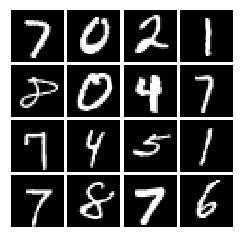

In [2]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    return tf.maximum(x, alpha*x)

def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform([batch_size, dim], -1, 1)

## Solvers from original GAN

In [3]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

## run_a_gan from original GAN

In [55]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # run a batch of data through the network
        minibatch, minibatch_y = mnist.train.next_batch(batch_size)
        minibatch_y = get_one_hot(minibatch_y, 10)
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample, feed_dict={y: minibatch_y})
            fig = show_images(samples[:16])
            plt.show()
            print()
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch, y: minibatch_y})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={y: minibatch_y})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample, feed_dict={y: minibatch_y})

    fig = show_images(samples[:16])
    plt.show()

# Original GAN setups
Except now with y, the inputs are the concatentation of two input vectors

In [14]:
def generator(z, y):
    with tf.variable_scope("generator"):
        inputs = tf.concat(axis=1, values=[z, y])
        fc1 = tf.layers.dense(inputs, 1024, tf.nn.relu)
        fc2 = tf.layers.dense(fc1, 1024, tf.nn.relu)
        fc3 = tf.layers.dense(fc2, 784)
        img = tf.tanh(fc3)
        return img


def discriminator(x, y):
    with tf.variable_scope("discriminator"):
        inputs = tf.concat(axis=1, values=[x, y])
        fc1 = tf.layers.dense(inputs, 256, leaky_relu)
        fc2 = tf.layers.dense(fc1, 256, leaky_relu)
        logits = tf.layers.dense(fc2, 1)
        return logits

## Original GAN loss

In [6]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits=logits_fake)
    G_loss = tf.reduce_mean(G_loss)

    D_loss1 = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real)
    D_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake)
    D_loss = tf.reduce_mean(D_loss1) + tf.reduce_mean(D_loss2)
    return D_loss, G_loss

## Original GAN setup
Except now with y

In [57]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# placeholder for images label from the training dataset
y = tf.placeholder(tf.float32, shape=[None, 10], name='y')
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z, y)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x), y)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample, y)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

## Training

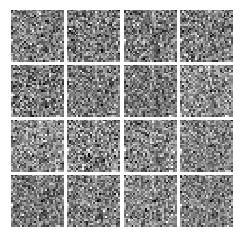


Iter: 0, D: 1.834, G:0.7239
Iter: 50, D: 0.2772, G:2.321
Iter: 100, D: 1.287, G:1.195
Iter: 150, D: 1.336, G:1.231
Iter: 200, D: 3.947, G:0.6682


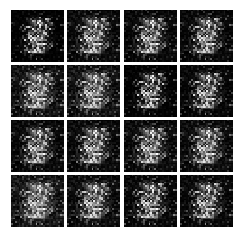


Iter: 250, D: 1.014, G:1.518
Iter: 300, D: 1.028, G:1.441
Iter: 350, D: 1.262, G:1.037
Iter: 400, D: 1.756, G:2.491
Iter: 450, D: 1.238, G:3.457


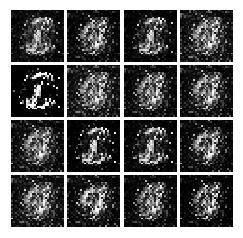


Iter: 500, D: 1.225, G:0.4373
Iter: 550, D: 0.9854, G:4.319
Iter: 600, D: 1.153, G:1.16
Iter: 650, D: 1.143, G:1.442
Iter: 700, D: 1.093, G:0.9047


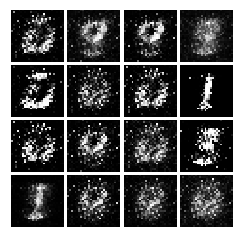


Iter: 750, D: 1.111, G:1.413
Iter: 800, D: 1.037, G:1.742
Iter: 850, D: 1.129, G:1.216
Iter: 900, D: 1.063, G:2.217
Iter: 950, D: 1.123, G:1.341


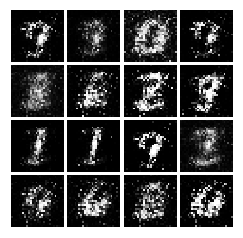


Iter: 1000, D: 1.148, G:1.052
Iter: 1050, D: 1.203, G:1.199
Iter: 1100, D: 1.283, G:1.103
Iter: 1150, D: 1.319, G:0.88
Iter: 1200, D: 1.222, G:1.075


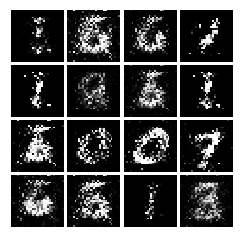


Iter: 1250, D: 1.265, G:0.9335
Iter: 1300, D: 1.28, G:0.9227
Iter: 1350, D: 1.232, G:0.9862
Iter: 1400, D: 1.206, G:0.8804
Iter: 1450, D: 1.198, G:1.331


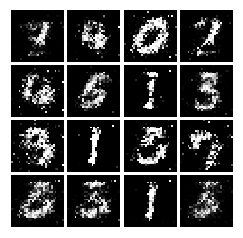


Iter: 1500, D: 1.164, G:0.9103
Iter: 1550, D: 1.267, G:0.9372
Iter: 1600, D: 1.244, G:0.8417
Iter: 1650, D: 1.271, G:1.006
Iter: 1700, D: 1.333, G:0.9278


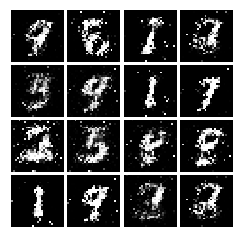


Iter: 1750, D: 1.194, G:1.439
Iter: 1800, D: 1.237, G:0.8932
Iter: 1850, D: 1.269, G:0.8618
Iter: 1900, D: 1.287, G:0.9981
Iter: 1950, D: 1.179, G:1.105


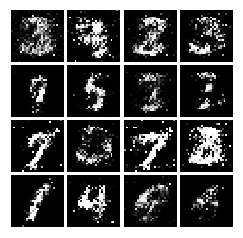


Iter: 2000, D: 1.343, G:0.9348
Iter: 2050, D: 1.299, G:0.8679
Iter: 2100, D: 1.303, G:0.8685
Iter: 2150, D: 1.36, G:0.8751
Iter: 2200, D: 1.331, G:0.9544


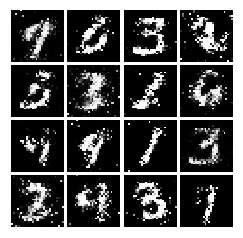


Iter: 2250, D: 1.178, G:0.8308
Iter: 2300, D: 1.275, G:0.8502
Iter: 2350, D: 1.351, G:0.8834
Iter: 2400, D: 1.273, G:0.7781
Iter: 2450, D: 1.242, G:0.8538


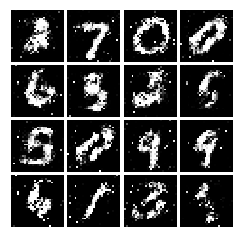


Iter: 2500, D: 1.311, G:0.8657
Iter: 2550, D: 1.303, G:0.8246
Iter: 2600, D: 1.326, G:0.9048
Iter: 2650, D: 1.254, G:0.8739
Iter: 2700, D: 1.234, G:0.9103


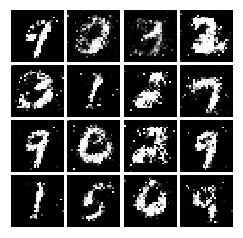


Iter: 2750, D: 1.295, G:0.9258
Iter: 2800, D: 1.282, G:0.9346
Iter: 2850, D: 1.273, G:0.8731
Iter: 2900, D: 1.326, G:0.7879
Iter: 2950, D: 1.323, G:0.8051


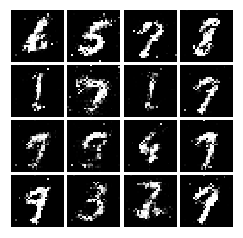


Iter: 3000, D: 1.21, G:0.8
Iter: 3050, D: 1.29, G:0.9168
Iter: 3100, D: 1.336, G:0.8215
Iter: 3150, D: 1.308, G:0.8852
Iter: 3200, D: 1.342, G:0.6895


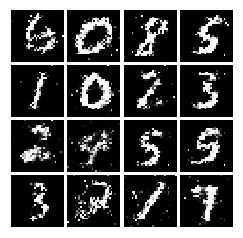


Iter: 3250, D: 1.266, G:0.9761
Iter: 3300, D: 1.325, G:0.8595
Iter: 3350, D: 1.28, G:0.9408
Iter: 3400, D: 1.273, G:0.8749
Iter: 3450, D: 1.338, G:0.8479


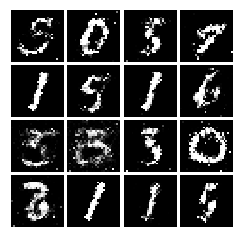


Iter: 3500, D: 1.288, G:0.7756
Iter: 3550, D: 1.362, G:0.8126
Iter: 3600, D: 1.303, G:0.7941
Iter: 3650, D: 1.344, G:0.8193
Iter: 3700, D: 1.303, G:0.9594


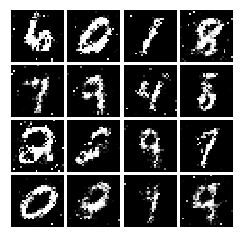


Iter: 3750, D: 1.307, G:0.6794
Iter: 3800, D: 1.322, G:0.7793
Iter: 3850, D: 1.351, G:0.7688
Iter: 3900, D: 1.346, G:0.7601
Iter: 3950, D: 1.351, G:0.8145


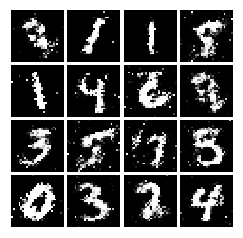


Iter: 4000, D: 1.422, G:0.8091
Iter: 4050, D: 1.337, G:0.7767
Iter: 4100, D: 1.291, G:0.7825
Iter: 4150, D: 1.283, G:0.8802
Iter: 4200, D: 1.323, G:0.7298


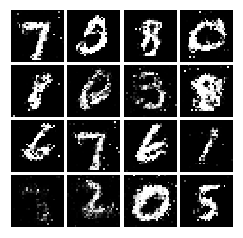


Iter: 4250, D: 1.321, G:0.8139
Final images


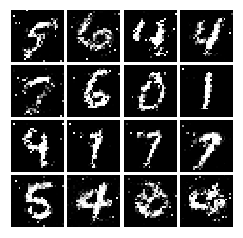

In [62]:
sess = get_session()
sess.run(tf.global_variables_initializer())
run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

## Results
Now with y, we can just sample images with desired labels.

<Figure size 720x576 with 0 Axes>

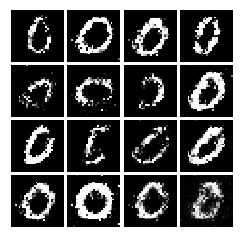

<Figure size 720x576 with 0 Axes>

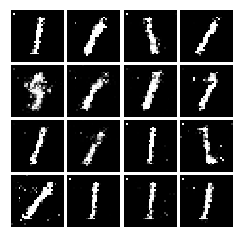

<Figure size 720x576 with 0 Axes>

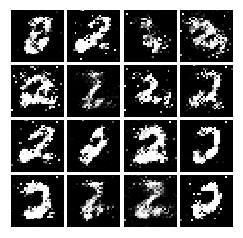

<Figure size 720x576 with 0 Axes>

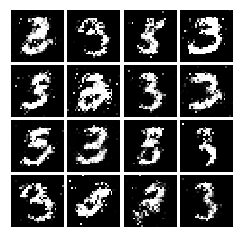

<Figure size 720x576 with 0 Axes>

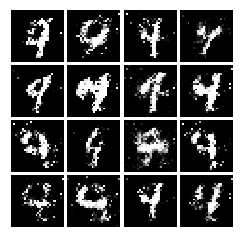

<Figure size 720x576 with 0 Axes>

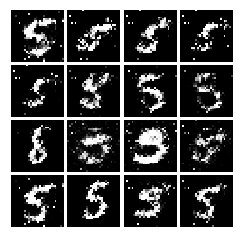

<Figure size 720x576 with 0 Axes>

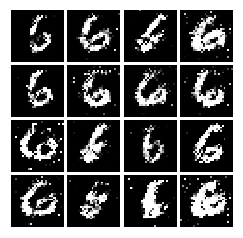

<Figure size 720x576 with 0 Axes>

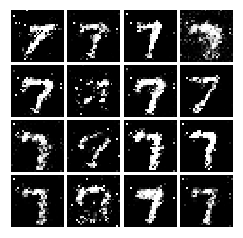

<Figure size 720x576 with 0 Axes>

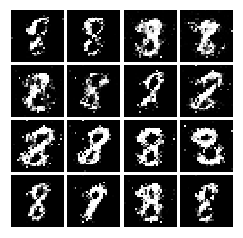

<Figure size 720x576 with 0 Axes>

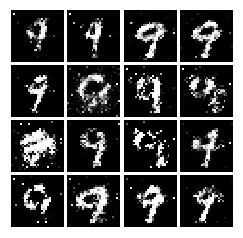

In [66]:
n_sample = 128
for i in range(10):
    y_sample = np.zeros(shape=[n_sample, 10])
    y_sample[:, i] = 1
    samples = sess.run(G_sample, feed_dict={y: y_sample})
    plt.figure(i)
    fig = show_images(samples[:16])
    plt.show()